In [2]:
%reset -f
%load_ext autoreload
%autoreload 2
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from scipy import constants
from subprocess import check_call,PIPE

import pvpy

import sys, types
def reload_package(root_module):
    package_name = root_module.__name__

    # get a reference to each loaded module
    loaded_package_modules = dict([
        (key, value) for key, value in sys.modules.items() 
        if key.startswith(package_name) and isinstance(value, types.ModuleType)])

    # delete references to these loaded modules from sys.modules
    for key in loaded_package_modules:
        del sys.modules[key]

    # load each of the modules again; 
    # make old modules share state with new modules
    for key in loaded_package_modules:
#         print 'loading %s' % key
        newmodule = __import__(key)
        oldmodule = loaded_package_modules[key]
        oldmodule.__dict__.clear()
        oldmodule.__dict__.update(newmodule.__dict__)

# Spectrums

## Plot a couple spectrums. How about the AM1.5G and a blackbody with T=5800 K, the default value

[ 1.1141]


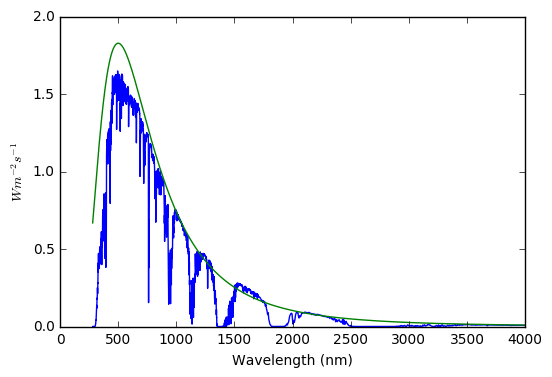

In [3]:
am15g = pvpy.PowerSpectrum(spectra="AM1.5G")
bb5800 = pvpy.PowerSpectrum(spectra="BlackBody", bbtemp=5800)
# The spectrum objects hold their spectrum as an Nx2 numpy array that you can call with the dot operator, 
# the __getitem__() method (aka square brackets[]), 
# or more formally via the get_spectrum() method
plt.plot(am15g[0], am15g[1], bb5800[0], bb5800[1])
plt.ylabel(r"$W m^{-2} s^{-1}$")
plt.xlabel("Wavelength (nm)")
print(am15g([400]))

## pvpy allows you to easily plot photon or photocurrent spectrums too. Either create the spectrum directly, or convert an existing spectrum to the desired.  Spectrum objects are: PowerSpectrum (W/m^2), PhotonSpectrum (photons / (m^2 s)), PhotocurrentSpectrum (A/m^2)

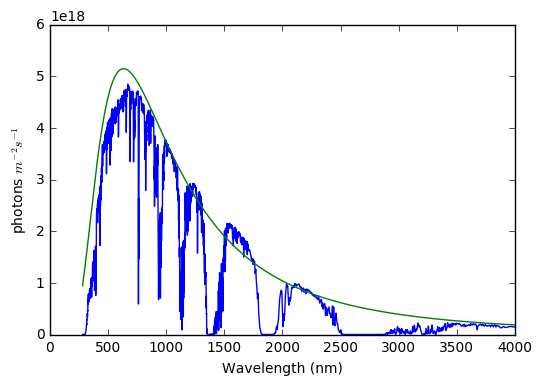

In [4]:
# create a photon spectrum directly
am15g = pvpy.PhotonSpectrum(spectra="AM1.5G")
# or convert the previous power spectrum
bb5800.to_PhotonSpectrum()
# The spectrum objects hold their spectrum as an Nx2 numpy array that you can call with the dot operator, or
# more formally via the get_spectrum() method
plt.plot(am15g[0], am15g[1], bb5800[0], bb5800[1])
plt.ylabel(r"photons $m^{-2} s^{-1}$")
plt.xlabel("Wavelength (nm)")

## pvpy was made with theortical photocurrent from an EQE spectrum in mind. How much photocurrent is in the AM1.5G spectrum below 1200nm? Feed the jsc() function a unity Nx2 EQE spectrum. The result is given in the common units of mA/cm^2.

In [77]:
wavelengths = np.arange(400, 1200)
EQE_spectrum = np.ones(wavelengths.shape)
EQE_spectrum = np.vstack((wavelengths, EQE_spectrum))
max_photocurrent0 = pvpy.jsc(EQE_spectrum)
# For a cell with non-perfect EQE
EQE_spectrum[1] = np.linspace(1, 0, len(wavelengths))
max_photocurrent1 = pvpy.jsc(EQE_spectrum)
print("Perfect EQE gives %0.2f mA/cm^2 and a linearly decreasing EQE give %0.2f mA/cm^2." % (max_photocurrent0, max_photocurrent1))

Perfect EQE gives 45.06 mA/cm^2 and a linearly decreasing EQE give 24.38 mA/cm^2.


# Detailed Balance Solar Cells

## pvpy includes detailed balance analysis for solar cells. Create a solar cell object, assign it properties such as bandgap, radiative (LED) effciency, temperature, ideality, absorbtivity, or tilt from sun. 
Future releases aim to include a double diode model, with series and shunt resistance. 

Create an illumination spectrum and illuminate the cell, then show the JV curve for the cell in the dark and in the light


The incident power on my Silicon cell is 1000.4 W/m^2 and it is 27.1 % efficient.


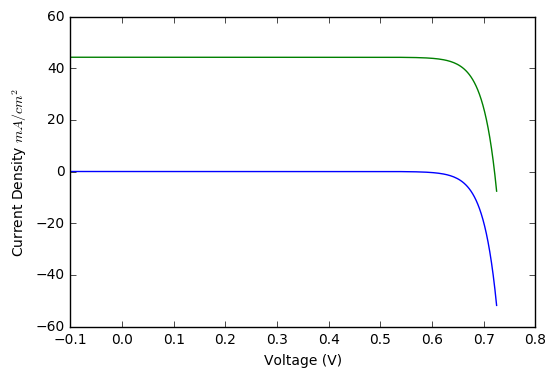

In [8]:
# SolarCell defaults are shown below. Assign other properties with the dot-operator
mysolarcell = pvpy.SolarCell(bandgap=1.1, celltemp=300, tilt=0, back_reflector=True)
mysolarcell.LED_eff = .01 # Silicon has poor LED efficiency
voltages = np.linspace(-.1, .725, 250)
#the cell outputs in SI units, A/m^2, use 0.1 to convert to mA/cm^2
dark_JV = mysolarcell.get_current(voltages) * .1 
plt.plot(voltages, dark_JV)

# create an illumination spectrum. The default black body spectrum is a sun with T=5800K
mysolarspectrum = pvpy.PhotonSpectrum(spectra="AM1.5G")
# illuminate the cell
mysolarcell.set_illumination(mysolarspectrum)
light_JV = mysolarcell.get_current(voltages) * .1
plt.plot(voltages, light_JV)
plt.ylabel(r"Current Density $mA/cm^{2}$")
plt.xlabel("Voltage (V)")
print("The incident power on my Silicon cell is %0.1f W/m^2 and it is %0.1f %% efficient." % (mysolarcell.incident_power, 100*mysolarcell.get_efficiency()))

## Recreate the famous efficiency versus bandgap curves for the 4 default illumination spectra. You can always define your own custom spectrum by passing a (2,N) numpy array to the ``spectra`` keyword

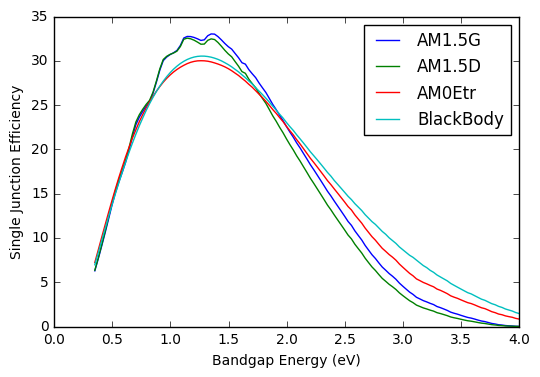

In [7]:
bandgaps = np.linspace(.35,4,125)
spectras = ["AM1.5G", "AM1.5D", "AM0Etr",  "BlackBody",]
for spectra in spectras:
    def effofbandgap(bandgap):
        cell = pvpy.SolarCell(bandgap=bandgap)
        spectrum = pvpy.PhotocurrentSpectrum(spectra=spectra)
        cell.set_illumination(spectrum)
        return cell.get_efficiency() *100
    effciencies = [effofbandgap(bandgap) for bandgap in bandgaps]
    plt.plot(bandgaps, effciencies)
plt.ylabel(r"Single Junction Efficiency")
plt.xlabel("Bandgap Energy (eV)")
plt.legend(spectras)